In [1]:
import sys
import os
import pandas as pd
import numpy as np
from importlib import reload

# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

# local import
sys.path.append("../")
from utils.trackmate import dataEngineering as _tm
from utils.visualization import generalPlots as _gplot
from utils.visualization import vectorPlots as _vplot
from utils.trackmate import spatialAnalysis as _stat

/home/cstansbu/.local/lib/python3.8/site-packages/libpysal/weights/util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


In [2]:
"""Load Data
"""

path = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/2021-05-12-BJ-PF-H2B-4OHT-AfterSort/analysis_files/CLEANED_TRACKS.csv"

df = pd.read_csv(path)
print(df.shape)
df.head()

(3803486, 71)


,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,STEP,NORMED_STEP,MEAN_GREEN_INTENSITY_SCALED,MEAN_BLUE_INTENSITY_SCALED,MEAN_RED_INTENSITY_SCALED,MEAN_OBLIQUE_INTENSITY_SCALED,MEAN_INTENSITY_SCALED,SCENE,MyoD,SERUM
0,ID23463,23463,C4_0,2.349,429.497,1836.179,0,0.000,0,10,...,0,0.000000,0.000000,0.0,0.0,0.838258,0.0,C4,+,HS
1,ID8192,8192,C4_0,2.895,432.123,1832.823,0,1337.248,1,10,...,1,0.000047,0.000000,0.0,0.0,0.588313,0.0,C4,+,HS
2,ID13445,13445,C4_0,2.326,431.302,1827.591,0,2674.496,2,10,...,2,0.000093,0.000000,0.0,0.0,0.000000,0.0,C4,+,HS
3,ID3542,3542,C4_0,2.646,432.208,1824.476,0,4011.744,3,10,...,3,0.000140,0.714933,0.0,1.0,0.742561,0.0,C4,+,HS
4,ID17874,17874,C4_0,2.345,434.819,1822.808,0,5348.992,4,10,...,4,0.000187,0.756790,0.0,0.0,0.722367,0.0,C4,+,HS


# Population Growth

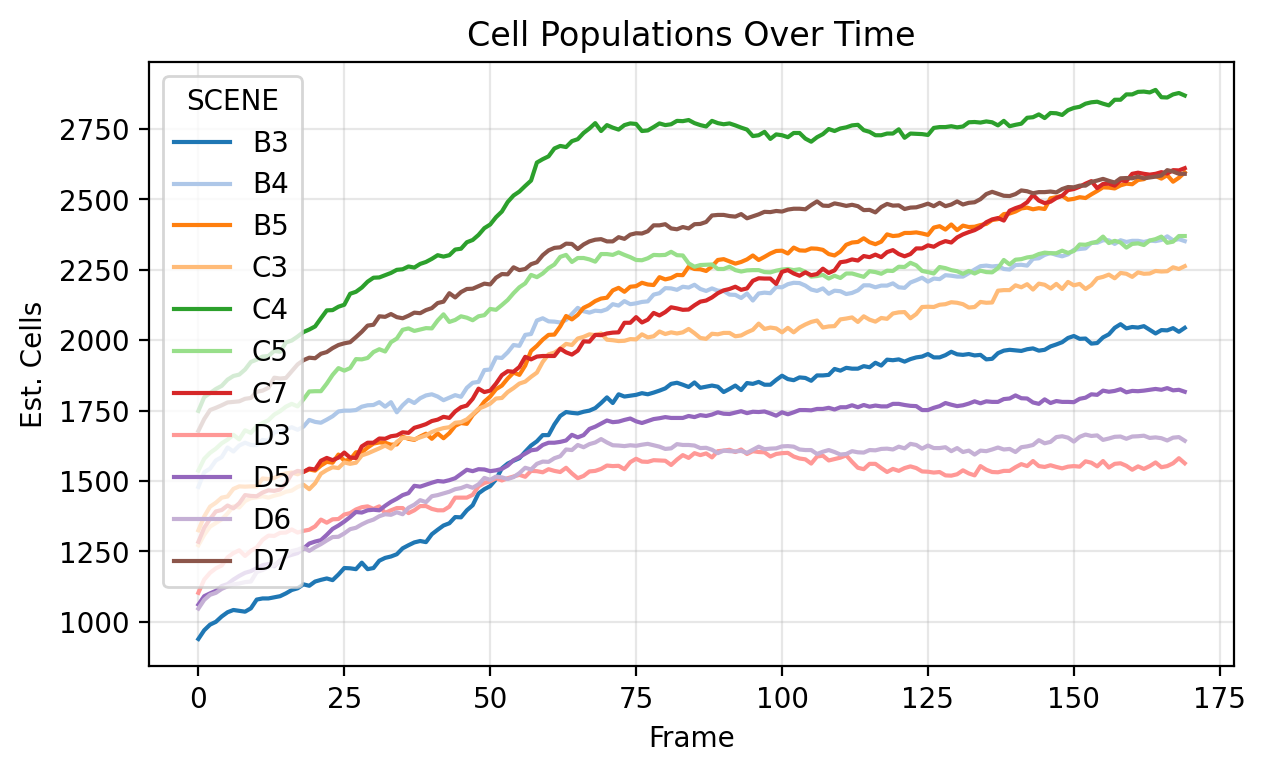

In [3]:
"""
groupy by time and scene
"""

by_frame = df.groupby(['FRAME', 'SCENE', 'MyoD', 'SERUM'], as_index=False).agg({
    'TRACK_ID' : 'nunique',
})

by_frame.head()

by_frame = by_frame[by_frame['FRAME'] < 170]

matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (7, 4)
sns.lineplot(data=by_frame,
            x='FRAME',
            y='TRACK_ID',
            hue='SCENE',
            palette='tab20')

plt.ylabel("Est. Cells")
plt.xlabel("Frame")
plt.title("Cell Populations Over Time")
plt.gca().set_axisbelow(True)
plt.grid(True, alpha=0.3)

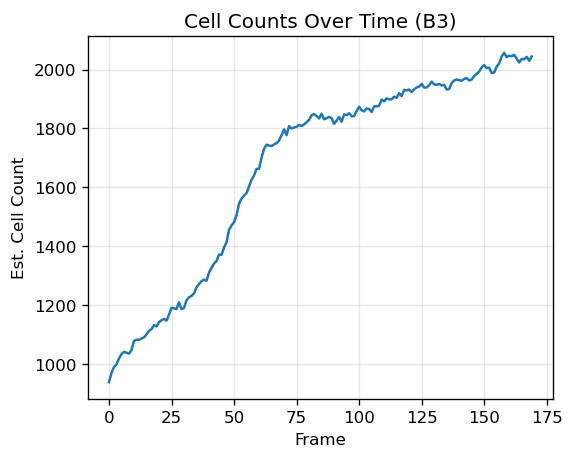

In [4]:
tmp = by_frame[by_frame['SCENE'] == 'B3']

matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['figure.figsize'] = (5, 4)
sns.lineplot(data=tmp,
            x='FRAME',
            y='TRACK_ID')

plt.ylabel("Est. Cell Count")
plt.xlabel("Frame")
plt.title("Cell Counts Over Time (B3)")
plt.gca().set_axisbelow(True)
plt.grid(True, alpha=0.3)

# Comparison to Watershed

In [5]:
"""WATERSHED ANALYSIS """

path = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/2021-05-12-BJ-PF-H2B-4OHT-AfterSort/analysis_files/B3_watershed_cell_counts.csv"

df2 = pd.read_csv(path)
print(df2.shape)
df2.head()

(177, 6)


,Slice,Count,Total Area,Average Size,%Area,Mean
0,c:2/4 t:1/177 - 2015-05-13-20-Scene2-B3.czi #1,1149,308456.346,268.456,2.060,255
1,c:2/4 t:2/177 - 2015-05-13-20-Scene2-B3.czi #1,1145,309862.927,270.623,2.069,255
2,c:2/4 t:3/177 - 2015-05-13-20-Scene2-B3.czi #1,1167,316699.835,271.379,2.115,255
3,c:2/4 t:4/177 - 2015-05-13-20-Scene2-B3.czi #1,1155,310081.985,268.469,2.071,255
4,c:2/4 t:5/177 - 2015-05-13-20-Scene2-B3.czi #1,1182,316430.816,267.708,2.113,255


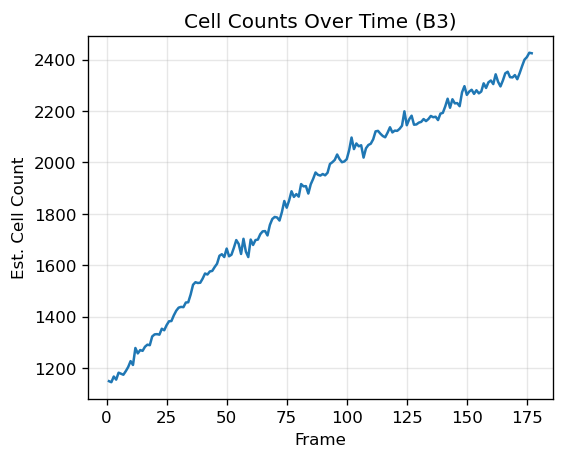

In [6]:
df2['FRAME'] = [x + 1 for x in range(len(df2))] 


matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['figure.figsize'] = (5, 4)
sns.lineplot(data=df2,
            x='FRAME',
            y='Count')

plt.ylabel("Est. Cell Count")
plt.xlabel("Frame")
plt.title("Cell Counts Over Time (B3)")
plt.gca().set_axisbelow(True)
plt.grid(True, alpha=0.3)

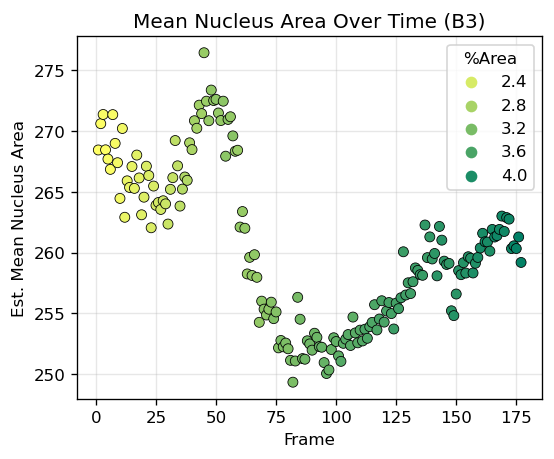

In [7]:
sns.scatterplot(data=df2, 
                x='FRAME',
                y='Average Size',
                edgecolor='k',
                hue='%Area',
                palette='summer_r')

plt.ylabel("Est. Mean Nucleus Area")
plt.xlabel("Frame")
plt.title("Mean Nucleus Area Over Time (B3)")
plt.gca().set_axisbelow(True)
plt.grid(True, alpha=0.3)

# Cell Densities

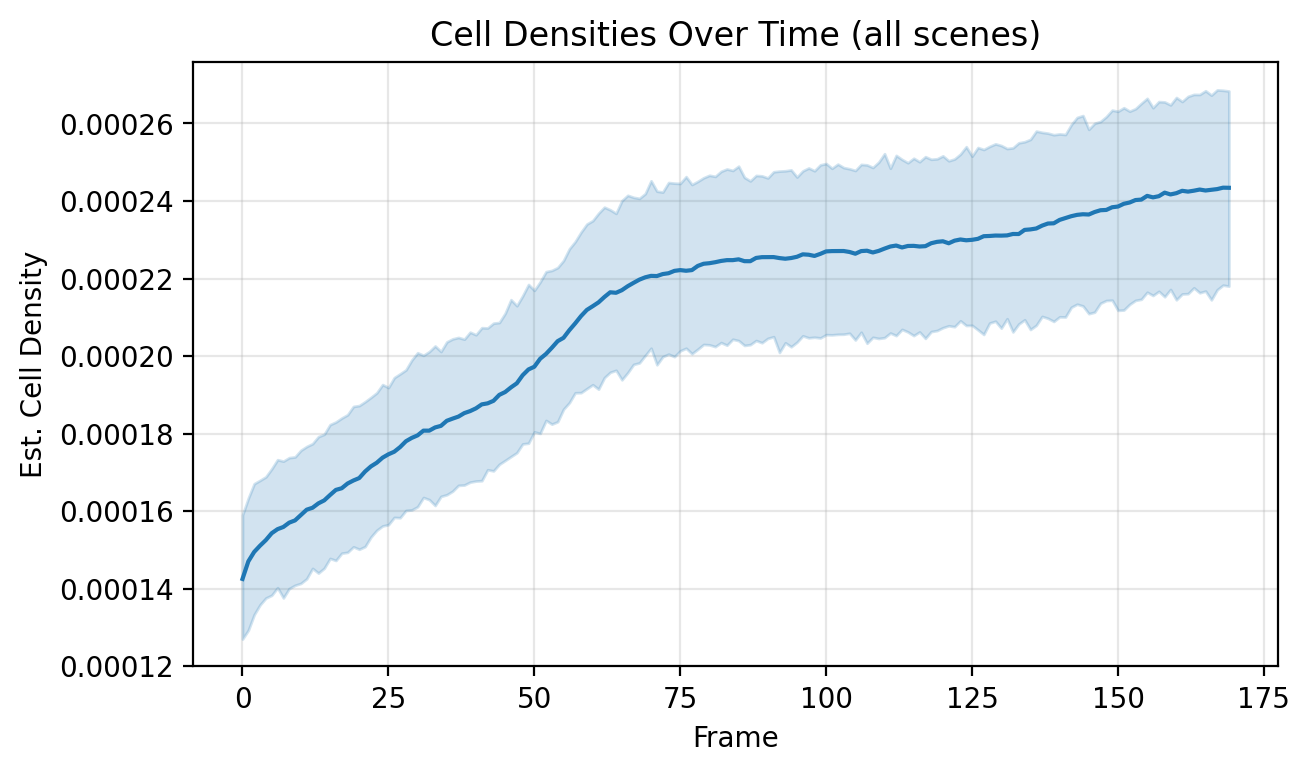

In [8]:
"""cell densities """
FRAME_SIZE = (652 * 6, 472 * 5)
FRAME_AREA = FRAME_SIZE[0] * FRAME_SIZE[1]

by_frame['DENSITY'] = by_frame['TRACK_ID'] / FRAME_AREA

matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (7, 4)
sns.lineplot(data=by_frame,
             x='FRAME',
             y='DENSITY')

plt.ylabel("Est. Cell Density")
plt.xlabel("Frame")
plt.title("Cell Densities Over Time (all scenes)")
plt.gca().set_axisbelow(True)
plt.grid(True, alpha=0.3)

/home/cstansbu/.local/lib/python3.8/site-packages/pointpats/centrography.py:229: RuntimeWarning: Mean of empty slice.
  m = points.mean(axis=0)
/home/cstansbu/.local/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/cstansbu/.local/lib/python3.8/site-packages/pointpats/centrography.py:230: RuntimeWarning: invalid value encountered in true_divide
  return np.sqrt(((points * points).sum(axis=0) / n - m * m).sum())


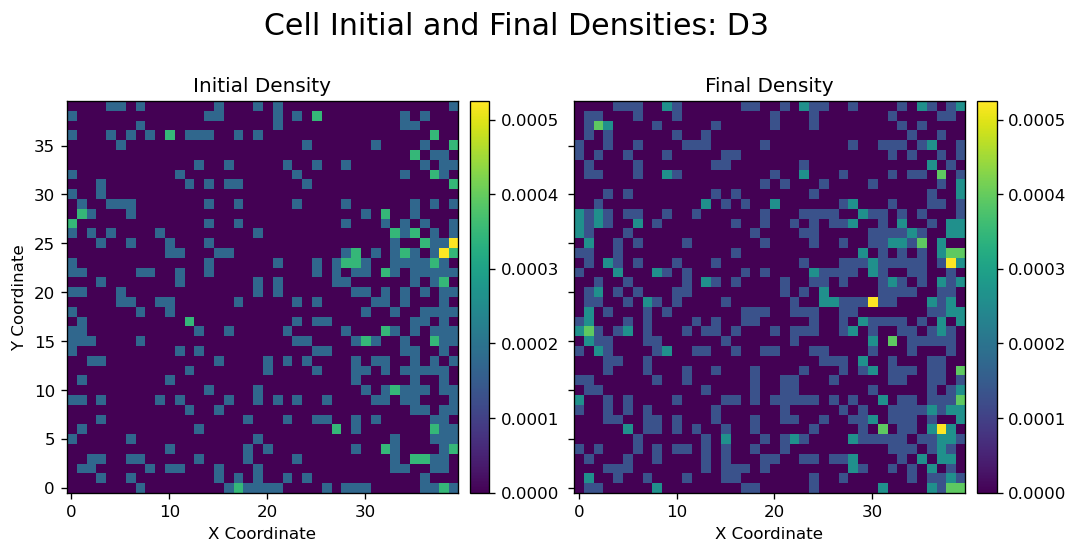

In [9]:
SIZE = 40
SCENE = 'D3'
FRAME_1 = 1
FRAME_2 = 170

tmp = df[df['SCENE'] == SCENE]

frame1 = tmp[tmp['FRAME'] == FRAME_1]
frame2 = tmp[tmp['FRAME'] == FRAME_2]

dens1, _ = _stat.get_densities(points=frame1[['POSITION_X', 'POSITION_Y']], 
                       frame_size=FRAME_SIZE, 
                       subregion_div=(SIZE, SIZE))

dens2, _ = _stat.get_densities(points=frame2[['POSITION_X', 'POSITION_Y']], 
                       frame_size=FRAME_SIZE, 
                       subregion_div=(SIZE, SIZE))


matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['figure.figsize'] = (10, 8)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

im1=ax1.imshow(dens1, interpolation='nearest', cmap='viridis', origin='lower')
ax1.set_title("Initial Density")
ax1.set_ylabel("Y Coordinate")
ax1.set_xlabel("X Coordinate")
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im1, cax=cax)


im2=ax2.imshow(dens2, interpolation='nearest', cmap='viridis', origin='lower')
ax2.set_title("Final Density")
ax2.set_xlabel("X Coordinate")
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im1, cax=cax)


plt.suptitle(f"Cell Initial and Final Densities: {SCENE}", fontsize=18, y=0.8)
plt.gca().set_axisbelow(True)
plt.grid(True, alpha=0.3)

# MyoD Effect

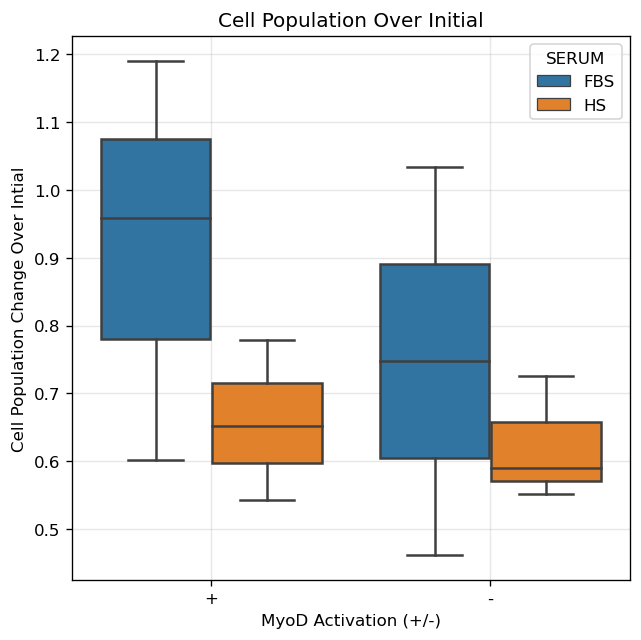

In [10]:
by_frame['SCENE_MIN'] = by_frame[['SCENE', 'TRACK_ID']].groupby('SCENE').transform('min')
by_frame['SCENE_MAX'] = by_frame[['SCENE', 'TRACK_ID']].groupby('SCENE').transform('max')

by_frame['POP_CHANGE'] = (by_frame['SCENE_MAX'] - by_frame['SCENE_MIN']) / by_frame['SCENE_MIN']


scenes = by_frame[['SCENE', 
                   'POP_CHANGE',
                   'SCENE_MIN',
                   'SCENE_MAX',
                   'MyoD',
                   'SERUM']].drop_duplicates()

matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['figure.figsize'] = (6, 6)


sns.boxplot(data=scenes,
            x='MyoD',
            y='POP_CHANGE',
            hue='SERUM')

plt.ylabel("Cell Population Change Over Intial")
plt.xlabel("MyoD Activation (+/-)")
plt.title("Cell Population Over Initial")

plt.gca().set_axisbelow(True)
plt.grid(True, alpha=0.3)

In [11]:
"""
t test of difference for MyoD
"""

from scipy import stats

myod_plus = by_frame[by_frame['MyoD'] == '+'][['SCENE', 'POP_CHANGE']].drop_duplicates()
myod_mins = by_frame[by_frame['MyoD'] == '-'][['SCENE', 'POP_CHANGE']].drop_duplicates()


stats.ttest_ind(myod_plus['POP_CHANGE'], 
                myod_mins['POP_CHANGE'])

Ttest_indResult(statistic=0.8027038201749561, pvalue=0.4428263155392834)

In [12]:
"""
t test of difference for MyoD
"""

from scipy import stats

fbs = by_frame[by_frame['SERUM'] == 'FBS'][['SCENE', 'POP_CHANGE']].drop_duplicates()
hs = by_frame[by_frame['SERUM'] == 'HS'][['SCENE', 'POP_CHANGE']].drop_duplicates()


stats.ttest_ind(fbs['POP_CHANGE'], 
                hs['POP_CHANGE'])

Ttest_indResult(statistic=1.5990907433426194, pvalue=0.14426476747950875)

# PIP FUCCI 

In [13]:
intense = df.groupby(['SCENE', 'FRAME'], as_index=False).agg({
     'MEAN_GREEN_INTENSITY_SCALED' : [np.sum,  'count'],
     'MEAN_RED_INTENSITY_SCALED' : [np.sum,  'count'],
    
})

intense['RED'] = intense['MEAN_RED_INTENSITY_SCALED']['sum'] / intense['MEAN_RED_INTENSITY_SCALED']['count']
intense['GREEN'] = intense['MEAN_GREEN_INTENSITY_SCALED']['sum'] / intense['MEAN_GREEN_INTENSITY_SCALED']['count']

intense['RED'] = np.where(intense['RED'] < 0.18, 0, intense['RED'])
intense['GREEN'] = np.where(intense['GREEN'] < 0.18, 0, intense['GREEN'])

intense.head()

SCENE FRAME MEAN_GREEN_INTENSITY_SCALED       MEAN_RED_INTENSITY_SCALED  \
                                      sum count                       sum   
0    B3     0                  334.874680   859                229.083928   
1    B3     1                  375.319979   886                267.788058   
2    B3     2                  394.705154   901                310.446746   
3    B3     3                  406.287661   916                318.087310   
4    B3     4                  416.177085   939                332.390475   

              RED     GREEN  
  count                      
0   926  0.247391  0.389842  
1   956  0.280113  0.423612  
2   976  0.318081  0.438075  
3   987  0.322277  0.443545  
4  1004  0.331066  0.443213

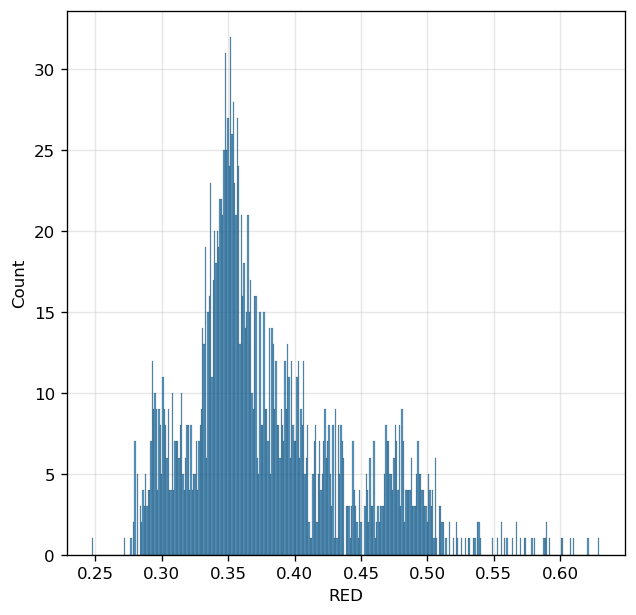

In [14]:
sns.histplot(data=intense,
             x='RED',
             binwidth=.001)

plt.gca().set_axisbelow(True)
plt.grid(True, alpha=0.3)

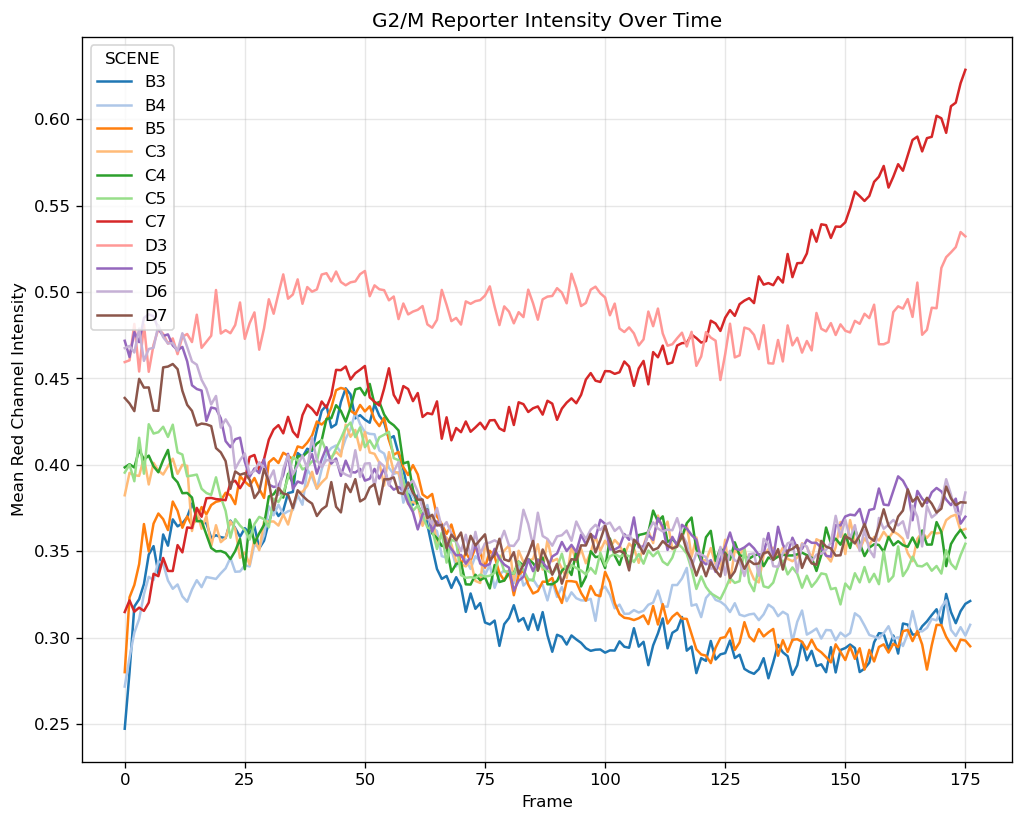

In [15]:
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['figure.figsize'] = (10, 8)
sns.lineplot(data=intense,
             x='FRAME',
             y='RED',
             hue='SCENE',
             palette='tab20')

plt.ylabel("Mean Red Channel Intensity")
plt.xlabel("Frame")
plt.title("G2/M Reporter Intensity Over Time")

plt.gca().set_axisbelow(True)
plt.grid(True, alpha=0.3)

In [16]:
df.head()

,LABEL,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,STEP,NORMED_STEP,MEAN_GREEN_INTENSITY_SCALED,MEAN_BLUE_INTENSITY_SCALED,MEAN_RED_INTENSITY_SCALED,MEAN_OBLIQUE_INTENSITY_SCALED,MEAN_INTENSITY_SCALED,SCENE,MyoD,SERUM
0,ID23463,23463,C4_0,2.349,429.497,1836.179,0,0.000,0,10,...,0,0.000000,0.000000,0.0,0.0,0.838258,0.0,C4,+,HS
1,ID8192,8192,C4_0,2.895,432.123,1832.823,0,1337.248,1,10,...,1,0.000047,0.000000,0.0,0.0,0.588313,0.0,C4,+,HS
2,ID13445,13445,C4_0,2.326,431.302,1827.591,0,2674.496,2,10,...,2,0.000093,0.000000,0.0,0.0,0.000000,0.0,C4,+,HS
3,ID3542,3542,C4_0,2.646,432.208,1824.476,0,4011.744,3,10,...,3,0.000140,0.714933,0.0,1.0,0.742561,0.0,C4,+,HS
4,ID17874,17874,C4_0,2.345,434.819,1822.808,0,5348.992,4,10,...,4,0.000187,0.756790,0.0,0.0,0.722367,0.0,C4,+,HS


(1041599, 71)


<ipython-input-18-d5008c10539b>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_24['HOUR'] = first_24['FRAME'] // (60/25)
<ipython-input-18-d5008c10539b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_24['STATE'] = first_24['MEAN_RED_INTENSITY_SCALED'] / (first_24['MEAN_GREEN_INTENSITY_SCALED'] + first_24['MEAN_RED_INTENSITY_SCALED'])
<ipython-input-18-d5008c10539b>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

TypeError: boxplot() got an unexpected keyword argument 'col'

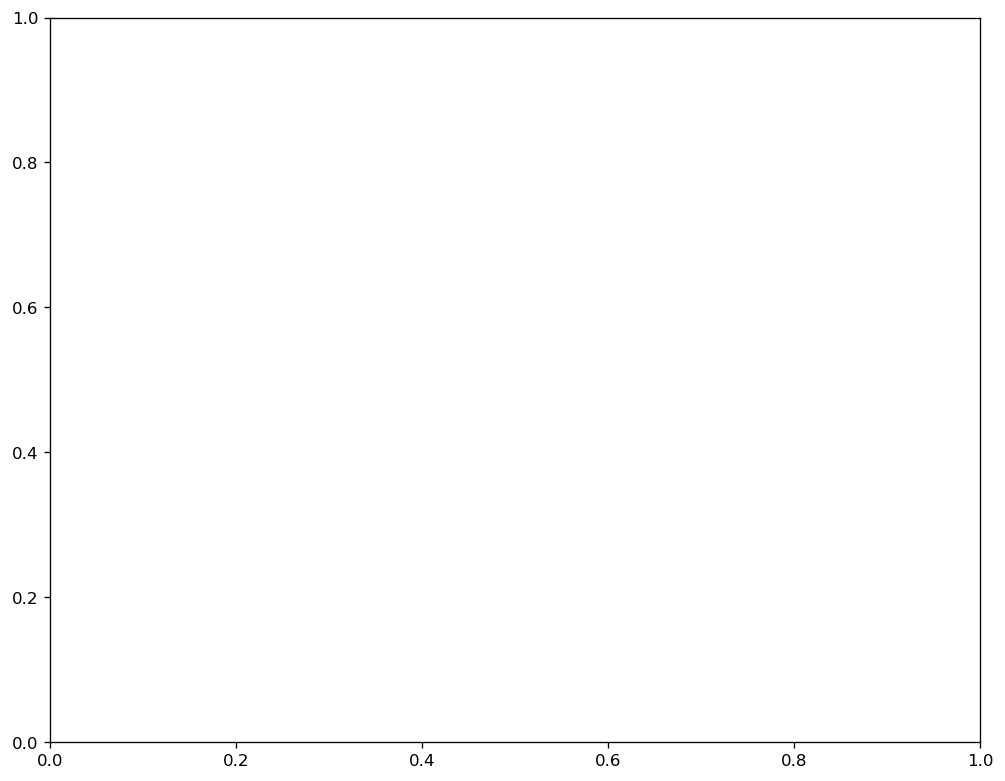

In [18]:
first_24 = df[(df['FRAME'] < 58)]
print(first_24.shape)


def get_phase(row):
    
    if row['STATE'] < 0.25:
        return 'G1'
    elif row['STATE'] >= 0.25and row['STATE'] <= 0.75:
        return 'G2/M'
    else:
        return 'S'
    

first_24['HOUR'] = first_24['FRAME'] // (60/25)
first_24['STATE'] = first_24['MEAN_RED_INTENSITY_SCALED'] / (first_24['MEAN_GREEN_INTENSITY_SCALED'] + first_24['MEAN_RED_INTENSITY_SCALED'])


first_24['PHASE'] = first_24.apply(lambda x: get_phase(x), axis=1)


first_24 = first_24.groupby(['SCENE', 'HOUR', 'PHASE', 'SERUM', 'MyoD'], as_index=False)['TRACK_ID'].count()


sns.boxplot(data=first_24,
                x='HOUR',
                y='TRACK_ID',
                col='MyoD',
                hue='PHASE',
                palette='RdYlGn_r',
                showfliers=False)